In [1]:
%load_ext autoreload
%autoreload 2

from utils.imports import *
from utils.plotting import *
from utils.config import DEFAULT_CONFIG as cfg
from utils.binary import get_blackhole_binary
from utils.star import evolve_star, relax_sph_realization
from amuse.ext.sink import new_sink_particles

%reload_ext autoreload 
%autoreload 2
%matplotlib inline
quantity_support()

@contextlib.contextmanager
def suppress_print():
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        yield

/home/boydjo/miniforge3/envs/amuse-env/lib/python3.12/site-packages/amuse/support/options.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
M1 = 30
M2 = 70
binary = get_blackhole_binary(M1, M2)
# m1=40m2=60a=0.2e=0.hdf5, m1=50m2=50a=0.2e=0.hdf5, m1=30m2=70a=0.2e=0.hdf5

In [3]:
mass_star = 1.0

N_sph = 5000
age = 1.0
M_core_fraction = 0.2

# Run the function
gas1, core_particle_set = evolve_star(mass_star, N_sph, age, M_core_fraction)

# Check
print("Gas particle set length:", len(gas1))
print("Core particle set length:", len(core_particle_set))

Gas particle set length: 5000
Core particle set length: 1


In [4]:
Gas1 = relax_sph_realization(gas1).copy()

In [5]:
%%time

# Sink prescriptions
def hydro_sink_particles(sinks, g):
    removed_particles = Particles()

    for s in sinks:
        xs, ys, zs = s.x, s.y, s.z
        radius_squared = ((s.mass / (10 | u.MSun)) | u.RSun)**2

        insink = g.select_array(
            lambda x, y, z: (x-xs)**2 + (y-ys)**2 + (z-zs)**2 < radius_squared,
            ['x', 'y', 'z']
        )

        if len(insink) > 0:
            s.mass += insink.total_mass()
            removed_particles.add_particles(insink)

    return removed_particles

def hydro_escape_sink(gas, binary, R_esc=1 | u.AU):
    removed_particles = Particles()
    Mtot = binary.mass.sum()
    xs, ys, zs = 0 | u.AU, 0 | u.AU, 0 | u.AU

    for p in gas:
        dx = p.x - xs
        dy = p.y - ys
        dz = p.z - zs

        r = (dx*dx + dy*dy + dz*dz).sqrt()
        v2 = p.vx*p.vx + p.vy*p.vy + p.vz*p.vz
        E = 0.5 * v2 - constants.G * Mtot / r

        if (r > R_esc) and (E > 0 | u.J / u.kg):
            removed_particles.add_particle(p)

    return removed_particles


# Load binary and gas

binary.position += [0, 0, 0] | u.AU
binary.rotate(0| u.rad, 0 | u.rad, 0 | u.rad)
# 0, (1/2)*np.pi, np.pi, (3/2)*np.pi

Gas1.position += [0, -0.4, 0] | u.AU

# Gravity solver

converter_grav = nbody_system.nbody_to_si(binary.mass.sum(), 1 | u.AU)
gravity = Ph4(converter_grav, mode="cpu_mode")

for k, v in cfg["Ph4"].items():
    setattr(gravity.parameters, k, v)

gravity.particles.add_particles(binary)


# Hydro solver

converter_hydro = nbody_system.nbody_to_si(1 | u.MSun, 1 | u.RSun)
hydro = Fi(converter_hydro)
hydro.gas_particles.add_particles(Gas1)
hydro.dm_particles.add_particles(core_particle_set)
hydro.parameters.self_gravity_flag = True
hydro.parameters.use_hydro_flag = True
hydro.parameters.gamma = 5.0 / 3.0
hydro.parameters.timestep = Gas1.dynamical_timescale() / 10


# Bridge coupling

bridge = Bridge(use_threading=True)
bridge.add_system(gravity, (hydro,))
bridge.add_system(hydro, (gravity,))
bridge.timestep = 10 * hydro.parameters.timestep


# Time control

time_step = bridge.timestep
time_end  = 300 * time_step
model_time = 0 | u.Myr


# Output: initial snapshot

write_set_to_file(
    [binary.savepoint(model_time), Gas1.savepoint(model_time)],
    "Lady_Tramp_70_30_0.hdf5", 
    # "Lady_Tramp_40_60_0.hdf5", "Lady_Tramp_40_60_05pi.hdf5","Lady_Tramp_40_60_pi.hdf5","Lady_Tramp_40_60_15pi.hdf5"
    # "Lady_Tramp_50_50_0.hdf5", "Lady_Tramp_50_50_05pi.hdf5","Lady_Tramp_50_50_pi.hdf5","Lady_Tramp_50_50_15pi.hdf5"
    # "Lady_Tramp_70_30_0.hdf5", "Lady_Tramp_70_30_05pi.hdf5","Lady_Tramp_70_30_pi.hdf5","Lady_Tramp_70_30_15pi.hdf5"
    'amuse',                  
    names=['binary', 'gas'],
    overwrite_file=True
)

accreted_gas = Particles()
escaped_gas = Particles()


# Main evolution loop
while model_time < time_end:

    # Advance time
    model_time += time_step
    bridge.evolve_model(model_time)

    print(f"{model_time/time_end:.3f}  (t = {model_time.in_(u.yr)})")

    
    if len(hydro.gas_particles) < 1:
        print(f"All gas gone at t = {model_time.in_(u.yr)}")
        break
        
    accreted = hydro_sink_particles(gravity.particles, hydro.gas_particles)
    if len(accreted) > 0:
        print("N accreted:", model_time.value_in(u.yr), len(accreted),
              "m=", accreted.mass.sum().in_(u.MSun))
        accreted_gas.add_particles(accreted)

    # --- Escaped gas ---
    escaped = hydro_escape_sink(hydro.gas_particles, binary, R_esc=1 | u.AU)
    if len(escaped) > 0:
        print("Escaped:", model_time.value_in(u.yr), len(escaped),
              escaped.mass.sum().in_(u.MSun))
        escaped_gas.add_particles(escaped)

    # --- Remove accreted + escaped particles from hydro and Gas1 ---
    to_remove = Particles()
    to_remove.add_particles(accreted)
    to_remove.add_particles(escaped)

    if len(to_remove) > 0:
        hydro.gas_particles.remove_particles(to_remove)
        Gas1.remove_particles(to_remove)

    print("Remaining gas particles:", len(hydro.gas_particles))

    # --- Synchronize binary and gas sets for output ---
    gravity.particles.new_channel_to(binary).copy()
    if len(hydro.gas_particles) > 0:
        hydro.gas_particles.new_channel_to(Gas1).copy()

    # --- Output snapshot ---
    write_set_to_file(
        [binary.savepoint(model_time), Gas1.savepoint(model_time)],
        "Lady_Tramp_70_30_0.hdf5",
        # "Lady_Tramp_40_60_0.hdf5", "Lady_Tramp_40_60_05pi.hdf5","Lady_Tramp_40_60_pi.hdf5","Lady_Tramp_40_60_15pi.hdf5"
        # "Lady_Tramp_50_50_0.hdf5", "Lady_Tramp_50_50_05pi.hdf5","Lady_Tramp_50_50_pi.hdf5","Lady_Tramp_50_50_15pi.hdf5"
        # "Lady_Tramp_70_30_0.hdf5", "Lady_Tramp_70_30_05pi.hdf5","Lady_Tramp_70_30_pi.hdf5","Lady_Tramp_70_30_15pi.hdf5"
        'amuse',
        names=['binary', 'gas'],
        append_to_file=True   
    )


# Cleanup

bridge.stop()
gravity.stop()
hydro.stop()


0.003  (t = 3.3e+03s)
Remaining gas particles: 5000
0.007  (t = 6.5e+03s)
Remaining gas particles: 5000
0.010  (t = 9.8e+03s)
Remaining gas particles: 5000
0.013  (t = 1.3e+04s)
Remaining gas particles: 5000
0.017  (t = 1.6e+04s)
Remaining gas particles: 5000
0.020  (t = 2.0e+04s)
Remaining gas particles: 5000
0.023  (t = 2.3e+04s)
Remaining gas particles: 5000
0.027  (t = 2.6e+04s)
Remaining gas particles: 5000
0.030  (t = 2.9e+04s)
Remaining gas particles: 5000
0.033  (t = 3.3e+04s)
Remaining gas particles: 5000
0.037  (t = 3.6e+04s)
Remaining gas particles: 5000
0.040  (t = 3.9e+04s)
Remaining gas particles: 5000
0.043  (t = 4.2e+04s)
Remaining gas particles: 5000
0.047  (t = 4.6e+04s)
Remaining gas particles: 5000
0.050  (t = 4.9e+04s)
Remaining gas particles: 5000
0.053  (t = 5.2e+04s)
Remaining gas particles: 5000
0.057  (t = 5.5e+04s)
Remaining gas particles: 5000
0.060  (t = 5.9e+04s)
Remaining gas particles: 5000
0.063  (t = 6.2e+04s)
Remaining gas particles: 5000
0.067  (t = 

0.523  (t = 5.1e+05s)
Remaining gas particles: 4998
0.527  (t = 5.1e+05s)
Remaining gas particles: 4998
0.530  (t = 5.2e+05s)
Remaining gas particles: 4998
0.533  (t = 5.2e+05s)
Remaining gas particles: 4998
0.537  (t = 5.2e+05s)
Remaining gas particles: 4998
0.540  (t = 5.3e+05s)
Remaining gas particles: 4998
0.543  (t = 5.3e+05s)
Remaining gas particles: 4998
0.547  (t = 5.3e+05s)
Remaining gas particles: 4998
0.550  (t = 5.4e+05s)
Remaining gas particles: 4998
0.553  (t = 5.4e+05s)
Remaining gas particles: 4998
0.557  (t = 5.4e+05s)
Remaining gas particles: 4998
0.560  (t = 5.5e+05s)
Remaining gas particles: 4998
0.563  (t = 5.5e+05s)
Remaining gas particles: 4998
0.567  (t = 5.5e+05s)
Remaining gas particles: 4998
0.570  (t = 5.6e+05s)
Remaining gas particles: 4998
0.573  (t = 5.6e+05s)
Remaining gas particles: 4998
0.577  (t = 5.6e+05s)
Remaining gas particles: 4998
0.580  (t = 5.7e+05s)
Remaining gas particles: 4998
0.583  (t = 5.7e+05s)
Remaining gas particles: 4998
0.587  (t = 

AmuseException: Error when calling 'get_position' of a 'Fi', errorcode is -1

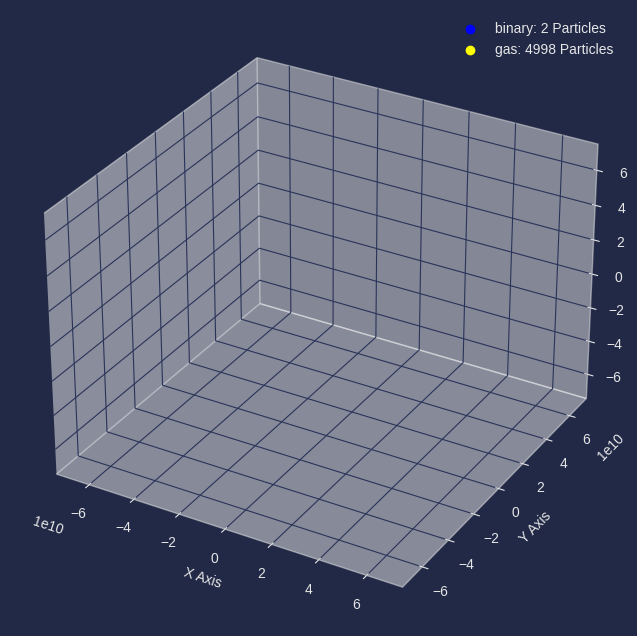

In [6]:
file =  read_set_from_file("Lady_Tramp_70_30_0.hdf5")
# "Lady_Tramp_40_60_0.hdf5", "Lady_Tramp_40_60_05pi.hdf5","Lady_Tramp_40_60_pi.hdf5","Lady_Tramp_40_60_15pi.hdf5"
# "Lady_Tramp_50_50_0.hdf5", "Lady_Tramp_50_50_05pi.hdf5","Lady_Tramp_50_50_pi.hdf5","Lady_Tramp_50_50_15pi.hdf5"
# "Lady_Tramp_70_30_0.hdf5", "Lady_Tramp_70_30_05pi.hdf5","Lady_Tramp_70_30_pi.hdf5","Lady_Tramp_70_30_15pi.hdf5"

lx,ly,lz = map(lambda i: i.as_astropy_quantity(), [(-0.5,0.5)|u.AU, (-0.5,0.5)|u.AU, (-0.5, 0.5)|u.AU])
pad = 0.1 * max(lx[1]-lx[0], ly[1]-ly[0], lz[1]-lz[0])
color_map = {'binary': 'blue', 'gas': 'yellow'}
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")
ax.axis('equal')
ax.axes.set(
    xlabel= 'X Axis', ylabel='Y Axis', zlabel = 'Z Axis',
    xlim = lx, ylim=ly, zlim=lz )
# plt.axis("off")


scatter_objs = {}
for key in file.keys():
    label = f"{key}: {len(file[key])} Particles"
    scatter_objs[key], = ax.plot(
        [], [], [], "o",
        color=color_map[key],
        label=label
    )

ax.legend()

def init():
    for key in scatter_objs:
        scatter_objs[key].set_data([],[])
        scatter_objs[key].set_3d_properties([])
    
    return scatter_objs.values(),

def update(frame):
    for key in scatter_objs:
        state = file[key].get_state_at_timestamp(frame)
        x,y,z = state.position.as_astropy_quantity().T
        scatter_objs[key].set_data(x,y); scatter_objs[key].set_3d_properties(z)
    # ax.set_title(f"time {frame.value_in(u.s)}")
    return scatter_objs.values(),

# Create the animation

ani = FuncAnimation(
    fig, update, frames=[i.get_timestamp().as_quantity_in(u.s) for i in file['gas'].history if i.get_timestamp() is not None]
,init_func=init, interval=100, blit=False
)

ani.save("Lady_Tramp_70_30_0.mp4", fps=30, dpi=150)
#"Lady_Tramp_40_60_0.mp4" "Lady_Tramp_40_60_05pi.mp4" "Lady_Tramp_40_60_pi.mp4"  "Lady_Tramp_40_60_15pi.mp4"
#"Lady_Tramp_50_50_0.mp4" "Lady_Tramp_50_50_05pi.mp4" "Lady_Tramp_50_50_pi.mp4" "Lady_Tramp_50_50_15pi.mp4"
# "Lady_Tramp_70_30_0.mp4" "Lady_Tramp_70_30_05pi.mp4" "Lady_Tramp_70_30_pi.mp4" "Lady_Tramp_70_30_15pi.mp4"